In [6]:
#package loading 
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy.stats import percentileofscore
from tqdm import tqdm
import cudf

In [ ]:
from utility import *

# 1. Read datasets

In [7]:
data_wd = "/data/datasets/Tianchen/2022_covid_pasc_1FL_data/20221020/covid_database"

In [8]:
# covid database
diagnosis_cov = pd.read_csv(data_wd+"/DIAGNOSIS.csv",header=0,skiprows=[1])
lab_result_cm_cov = pd.read_csv(data_wd+"/LAB_RESULT_CM.csv",header=0,skiprows=[1])
obs_gen_cov = pd.read_csv(data_wd+"/OBS_GEN.csv",header=0,skiprows=[1])
procedure_cov = pd.read_csv(data_wd+"/PROCEDURES.csv",header=0,skiprows=[1])
demographics_cov = pd.read_csv(data_wd+"/DEMOGRAPHIC.csv",header=0,skiprows=[1])

/tmp/ipykernel_25999/3208235642.py:2: DtypeWarning: Columns (7,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  diagnosis_cov = pd.read_csv(data_wd+"/DIAGNOSIS.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3208235642.py:3: DtypeWarning: Columns (2,3,5,6,9,10,12,13,15,17,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  lab_result_cm_cov = pd.read_csv(data_wd+"/LAB_RESULT_CM.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3208235642.py:4: DtypeWarning: Columns (6,7,9,10,13,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gen_cov = pd.read_csv(data_wd+"/OBS_GEN.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3208235642.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  procedure_cov = pd.read_csv(data_wd+"/PROCEDURES.csv",header=0,skiprows=[1])


In [9]:
data_wd = "/data/datasets/Tianchen/2022_covid_pasc_1FL_data/20221020/main_database"

In [10]:
# general database
diagnosis_m = pd.read_csv(data_wd+"/DIAGNOSIS.csv",header=0,skiprows=[1])
lab_result_cm_m = pd.read_csv(data_wd+"/LAB_RESULT_CM.csv",header=0,skiprows=[1])
obs_gen_m = pd.read_csv(data_wd+"/OBS_GEN.csv",header=0,skiprows=[1])
procedure_m = pd.read_csv(data_wd+"/PROCEDURES.csv",header=0,skiprows=[1])
demographics_m = pd.read_csv(data_wd+"/DEMOGRAPHIC.csv",header=0,skiprows=[1])

/tmp/ipykernel_25999/3211017016.py:2: DtypeWarning: Columns (7,8,12) have mixed types. Specify dtype option on import or set low_memory=False.
  diagnosis_m = pd.read_csv(data_wd+"/DIAGNOSIS.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3211017016.py:3: DtypeWarning: Columns (9,10,12,13,17,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  lab_result_cm_m = pd.read_csv(data_wd+"/LAB_RESULT_CM.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3211017016.py:4: DtypeWarning: Columns (6,7,9,10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gen_m = pd.read_csv(data_wd+"/OBS_GEN.csv",header=0,skiprows=[1])
/tmp/ipykernel_25999/3211017016.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  procedure_m = pd.read_csv(data_wd+"/PROCEDURES.csv",header=0,skiprows=[1])


In [11]:
print(diagnosis_m.columns == diagnosis_cov.columns)
print(lab_result_cm_m.columns == lab_result_cm_cov.columns)
print(obs_gen_m.columns == obs_gen_cov.columns)
print(procedure_m.columns == procedure_cov.columns)
print(demographics_m.columns == demographics_cov.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]


In [12]:
# union them
diagnosis = pd.concat([diagnosis_m,diagnosis_cov])
print("complete diagnosis")
lab_result_cm = pd.concat([lab_result_cm_m,lab_result_cm_cov])
print("complete lab_result_cm")
obs_gen = pd.concat([obs_gen_m,obs_gen_cov])
print("complete obs_gen")
procedure = pd.concat([procedure_m,procedure_cov])
print("complete procedure")
demographics = pd.concat([demographics_m,demographics_cov])
print("complete demographics")

complete diagnosis
complete lab_result_cm
complete obs_gen
complete procedure
complete demographics


In [13]:
#release memory
del(diagnosis_m)
del(diagnosis_cov)
del(lab_result_cm_m)
del(lab_result_cm_cov)
del(obs_gen_m)
del(obs_gen_cov)
del(procedure_m)
del(procedure_cov)
del(demographics_m)
del(demographics_cov)

# 2. Extract COVID patients

## 2.1 import index date and cohort definition

In [14]:
#pasc and covid inex dates
index_date = pd.read_csv('/data/datasets/Tianchen/2022_covid_pasc_1FL_data/20221020/covid_pasc_cohort.csv')

In [15]:
index_date['group'].value_counts()

cont    224041
case      5651
Name: group, dtype: int64

In [16]:
index_date.head()

,ID,index_date,pasc_onset_date,group
0,19Oct2022covidpasc00003601,2022-01-13,NaN,cont
1,19Oct2022covidpasc00003602,2020-09-30,NaN,cont
2,19Oct2022covidpasc00003603,2020-06-15,NaN,cont
3,19Oct2022covidpasc00003604,2020-07-07,NaN,cont
4,19Oct2022covidpasc00003605,2021-01-13,NaN,cont


## 2.2 choose those with covid19 index date

In [17]:
#choose those with covid19 index date
index_date = index_date.loc[~index_date['index_date'].isna()]

In [18]:
index_date['group'].value_counts()

cont    224041
case      1937
Name: group, dtype: int64

## 2.3 choose those with pasc date after covid date

In [19]:
index_date['index_date'] = pd.to_datetime(index_date['index_date'])
index_date['pasc_onset_date'] = pd.to_datetime(index_date['pasc_onset_date'])

In [20]:
index_date = index_date.loc[(index_date['index_date']<index_date['pasc_onset_date'])|index_date['pasc_onset_date'].isna()]

In [21]:
index_date['group'].value_counts()

cont    224041
case      1706
Name: group, dtype: int64

# 3. Demographics preprocessing

## 3.1 drop duplicate

In [22]:
# This is because there are two database to be merged, i.e. covid database and general databse. The medical records are not duplicates abut the patient demographics are.
print(demographics.shape)
demographics = demographics.drop_duplicates(['ID'])
print(demographics.shape)

(455995, 12)
(229689, 12)


## 3.1 1st filter by index date cohorts

In [23]:
#pair demographics and index date
print(demographics.shape)
demographics = pd.merge(demographics,index_date,left_on='ID',right_on='ID',how='inner')
demographics = demographics[['ID', 'index_date','pasc_onset_date']]
print(demographics.shape)

(229689, 12)
(225744, 3)


# 4. Extract cancer patient cohort by ICD codes

## 4.1 From Diagnosis

In [24]:
print(diagnosis.columns)
diagnosis.head()

Index(['DIAGNOSISID', 'ID', 'ENCOUNTERID', 'ENC_TYPE', 'ADMIT_DATE',
       'PROVIDERID', 'DX', 'DX_TYPE', 'DX_DATE', 'DX_SOURCE', 'DX_ORIGIN',
       'PDX', 'DX_POA', 'SOURCE_masked'],
      dtype='object')


,DIAGNOSISID,ID,ENCOUNTERID,ENC_TYPE,ADMIT_DATE,PROVIDERID,DX,DX_TYPE,DX_DATE,DX_SOURCE,DX_ORIGIN,PDX,DX_POA,SOURCE_masked
0,cfhOcroEQlKorQC+,19Oct2022covidpasc00089945,cfhOcbsFSV6trgI=,IP,2017-11-09,cfhOcrkLSlE=,K21.9,10,NaN,DI,BI,S,Y,source_3
1,cfhOcroEQlKorQC/,19Oct2022covidpasc00089945,cfhOcbsFSV6trgI=,IP,2017-11-09,cfhOcrkLSlE=,M19.90,10,NaN,DI,BI,S,Y,source_3
2,cfhOcroEQlKorQC4,19Oct2022covidpasc00089945,cfhOcbsFSV6trgI=,IP,2017-11-09,cfhOcrkLSlE=,E78.5,10,NaN,DI,BI,S,Y,source_3
3,cfhOcroEQlKorQC5,19Oct2022covidpasc00089945,cfhOcbsFSV6trgI=,IP,2017-11-09,cfhOcrkLSlE=,I10,10,NaN,DI,BI,S,Y,source_3
4,cfhOcroEQlKorQC6,19Oct2022covidpasc00089945,cfhOcbsFSV6trgI=,IP,2017-11-09,cfhOcrkLSlE=,I25.10,10,NaN,DI,BI,S,Y,source_3


In [25]:
#Diagnosis ID
cond_9_search = tuple(["140","141","142","143","144","145","146","147","148","149",\
                       "150","151","152","153","154","155","156","157","158","159",\
                       "160","161","162","163","164","165","166","167","168","169",\
                       "170","171","172","173","174","175","176","177","178","179",\
                       "180","181","182","183","184","185","186","187","188","189",\
                       "190","191","192","193","194",\
                       "195.0","195.1","195.2","195.3","195.4","195.5","195.6","195.7","195.8",\
                       "1950","1951","1952","1953","1954","1955","1956","1957","1958",\
                       "200","201","202","203","204","205","206","207","208","238.6","2386"])
cond_10_search = tuple(["C00","C01","C02","C03","C04","C05","C06","C07","C08","C09",\
                       "C10","C11","C12","C13","C14","C15","C16","C17","C18","C19",\
                       "C20","C21","C22","C23","C24","C25","C26","C30","C31","C32",\
                       "C33","C34","C37","C38","C39","C40","C41","C43","C45","C46",\
                       "C47","C48","C49","C50","C51","C52","C53","C54","C55","C56",\
                       "C57","C58","C60","C61","C62","C63","C64","C65","C66","C67",\
                        "C68","C69","C70","C71","C72","C73","C74","C75","C76","C81",\
                        "C82","C83","C84","C85","C88","C90","C91","C92","C93","C94",\
                        "C95","C96","C97"])
cond_9_add = diagnosis.DX == "195"
cond_9_search_result = diagnosis.DX.str.startswith(cond_9_search,na=False)
cond_10_search_result = diagnosis.DX.str.startswith(cond_10_search,na=False)

In [26]:
#Diagnosis vocabulary type
print(set(diagnosis['DX_TYPE']))
print(diagnosis['DX_TYPE'].value_counts())

{9, 10, '10', 'SM', 'OT', '09'}
10    114479274
9      25905869
10      1384179
09       249695
SM         4465
OT           61
Name: DX_TYPE, dtype: int64


In [27]:
cond_9_type = diagnosis['DX_TYPE'].isin(['09','9',9])
cond_10_type = diagnosis['DX_TYPE'].isin(['10',10])

In [28]:
print(np.sum(cond_9_type)-25905869-249695)
print(np.sum(cond_10_type)- 114479274-1384179)

0
0


In [29]:
cond_final = ( (cond_9_type&(cond_9_add|cond_9_search_result)) | (cond_10_type&cond_10_search_result) )
print(np.sum(cond_final))

1637292


In [30]:
all_cancer_diagnosis = diagnosis.loc[cond_final][['DX','ID','DX_TYPE']].drop_duplicates().reset_index(drop=True)
all_cancer_diagnosis['domain'] = 'diagnosis'

In [31]:
print(all_cancer_diagnosis.shape)
all_cancer_diagnosis.head()

(65499, 4)


,DX,ID,DX_TYPE,domain
0,173.59,19Oct2022covidpasc00001980,9,diagnosis
1,C61,19Oct2022covidpasc00151597,10,diagnosis
2,C49.3,19Oct2022covidpasc00201094,10,diagnosis
3,C61,19Oct2022covidpasc00000881,10,diagnosis
4,C40.21,19Oct2022covidpasc00200080,10,diagnosis


In [32]:
all_cancer_diagnosis.shape

(65499, 4)

## 4.2 From Procedure

In [33]:
print(procedure.columns)
procedure.head()

Index(['PROCEDURESID', 'ID', 'ENCOUNTERID', 'ENC_TYPE', 'ADMIT_DATE',
       'PROVIDERID', 'PX_DATE', 'PX', 'PX_TYPE', 'PX_SOURCE', 'PPX',
       'SOURCE_masked'],
      dtype='object')


,PROCEDURESID,ID,ENCOUNTERID,ENC_TYPE,ADMIT_DATE,PROVIDERID,PX_DATE,PX,PX_TYPE,PX_SOURCE,PPX,SOURCE_masked
0,cfhOcb0DTlShowY=,19Oct2022covidpasc00035975,cfhOd78BSVKhqA==,IP,2015-12-09,cfhOdrEAQg==,2015-12-12,85025,CH,BI,NI,source_3
1,cfhOcb0DTlShqQQ=,19Oct2022covidpasc00103273,cfhOerwBTl6how==,IP,2015-02-12,cfhOcb0HSw==,2015-02-17,99472,CH,BI,NI,source_3
2,cfhOcb0DTlShrg==,19Oct2022covidpasc00059292,cfhOcrsLS1Kvrg==,ED,2014-05-29,cfhOe7gF,2014-05-29,99283,CH,BI,NI,source_3
3,cfhOcb0DTlSoqw0=,19Oct2022covidpasc00067850,cfhOdL0AQ1Csow==,AV,2012-06-29,cfhOcrkHQ1E=,2012-06-29,84480,CH,BI,NI,source_3
4,cfhOcb0DTlSorwU=,19Oct2022covidpasc00178296,cfhOdrEETVeh,AV,2012-04-25,cfhOerk=,2012-04-25,90807,CH,BI,NI,source_3


In [34]:
#Diagnosis vocabulary type
print(set(procedure['PX_TYPE']))
print(procedure['PX_TYPE'].value_counts())

{'CH', '10', 'OT', 'NI', '09', 'RE'}
CH    126246440
RE     25087126
10      1197371
OT       819425
09       765631
NI         6296
Name: PX_TYPE, dtype: int64


In [35]:
cond_9_type = procedure['PX_TYPE'].isin(['09','9',9])
cond_10_type = procedure['PX_TYPE'].isin(['10',10])

In [36]:
print(np.sum(cond_9_type)-765631)
print(np.sum(cond_10_type)- 1197371)

0
0


In [37]:
#Diagnosis ID
cond_9_search = tuple(["140","141","142","143","144","145","146","147","148","149",\
                       "150","151","152","153","154","155","156","157","158","159",\
                       "160","161","162","163","164","165","166","167","168","169",\
                       "170","171","172","173","174","175","176","177","178","179",\
                       "180","181","182","183","184","185","186","187","188","189",\
                       "190","191","192","193","194",\
                       "195.0","195.1","195.2","195.3","195.4","195.5","195.6","195.7","195.8",\
                       "1950","1951","1952","1953","1954","1955","1956","1957","1958",\
                       "200","201","202","203","204","205","206","207","208","238.6","2386"])
cond_10_search = tuple(["C00","C01","C02","C03","C04","C05","C06","C07","C08","C09",\
                       "C10","C11","C12","C13","C14","C15","C16","C17","C18","C19",\
                       "C20","C21","C22","C23","C24","C25","C26","C30","C31","C32",\
                       "C33","C34","C37","C38","C39","C40","C41","C43","C45","C46",\
                       "C47","C48","C49","C50","C51","C52","C53","C54","C55","C56",\
                       "C57","C58","C60","C61","C62","C63","C64","C65","C66","C67",\
                        "C68","C69","C70","C71","C72","C73","C74","C75","C76","C81",\
                        "C82","C83","C84","C85","C88","C90","C91","C92","C93","C94",\
                        "C95","C96","C97"])
cond_9_add = procedure.PX == "195"
cond_9_search_result = procedure.PX.str.startswith(cond_9_search,na=False)
cond_10_search_result = procedure.PX.str.startswith(cond_10_search,na=False)

In [38]:
cond_final = ( (cond_9_type&(cond_9_add|cond_9_search_result)) | (cond_10_type&cond_10_search_result) )
print(np.sum(cond_final))

676


In [39]:
all_cancer_procedure = procedure.loc[cond_final][['PX','ID','PX_TYPE']].drop_duplicates().reset_index(drop=True)
all_cancer_procedure['domain'] = 'procedure'
all_cancer_procedure.columns = ['DX','ID','DX_TYPE','domain']
print(all_cancer_procedure.shape)
all_cancer_procedure.head()

(312, 4)


,DX,ID,DX_TYPE,domain
0,C21G1ZZ,19Oct2022covidpasc00032405,10,procedure
1,C21G1ZZ,19Oct2022covidpasc00018459,10,procedure
2,1742,19Oct2022covidpasc00182968,09,procedure
3,1424,19Oct2022covidpasc00107597,09,procedure
4,1474,19Oct2022covidpasc00107597,09,procedure


In [40]:
set(all_cancer_procedure['DX'])

{'1424',
 '1439',
 '1454',
 '1459',
 '1473',
 '1474',
 '1475',
 '1479',
 '149',
 '1511',
 '1631',
 '1711',
 '1712',
 '1713',
 '1724',
 '1733',
 '1735',
 '1736',
 '1741',
 '1742',
 '1749',
 '1753',
 '1755',
 '1756',
 '1781',
 '1829',
 '184',
 '194',
 '2001',
 '2009',
 '201',
 '2042',
 '2049',
 'C0101ZZ',
 'C010YZZ',
 'C015DZZ',
 'C030KZZ',
 'C030YZZ',
 'C2161ZZ',
 'C21G1ZZ',
 'C21GYZZ',
 'C21YYZZ',
 'C22G1ZZ',
 'C22GSZZ',
 'C23GYZZ',
 'C71L1ZZ',
 'C71LYZZ'}

In [62]:
all_cancer_procedure = all_cancer_procedure.loc[~all_cancer_procedure['DX'].isin([ 'C0101ZZ',
 'C010YZZ',
 'C015DZZ',
 'C030KZZ',
 'C030YZZ',
 'C2161ZZ',
 'C21G1ZZ',
 'C21GYZZ',
 'C21YYZZ',
 'C22G1ZZ',
 'C22GSZZ',
 'C23GYZZ',
 'C71L1ZZ',
 'C71LYZZ'])]

## 4.3 From lab

In [49]:
print(lab_result_cm.columns)
lab_result_cm.head()

Index(['LAB_RESULT_CM_ID', 'ID', 'ENCOUNTERID', 'SPECIMEN_SOURCE', 'LAB_LOINC',
       'LAB_RESULT_SOURCE', 'LAB_LOINC_SOURCE', 'PRIORITY', 'RESULT_LOC',
       'LAB_PX', 'LAB_PX_TYPE', 'LAB_ORDER_DATE', 'SPECIMEN_DATE',
       'SPECIMEN_TIME', 'RESULT_DATE', 'RESULT_TIME', 'RESULT_QUAL',
       'RESULT_SNOMED', 'RESULT_NUM', 'RESULT_MODIFIER', 'RESULT_UNIT',
       'NORM_RANGE_LOW', 'NORM_MODIFIER_LOW', 'NORM_RANGE_HIGH',
       'NORM_MODIFIER_HIGH', 'ABN_IND', 'SOURCE_masked'],
      dtype='object')


,LAB_RESULT_CM_ID,ID,ENCOUNTERID,SPECIMEN_SOURCE,LAB_LOINC,LAB_RESULT_SOURCE,LAB_LOINC_SOURCE,PRIORITY,RESULT_LOC,LAB_PX,...,RESULT_SNOMED,RESULT_NUM,RESULT_MODIFIER,RESULT_UNIT,NORM_RANGE_LOW,NORM_MODIFIER_LOW,NORM_RANGE_HIGH,NORM_MODIFIER_HIGH,ABN_IND,SOURCE_masked
0,cfhOcbEKSlSqrw0=,19Oct2022covidpasc00151140,cfhOcrgES1arogw=,SER_PLAS,2823-3,OD,DW,S,L,LAB15,...,NaN,3.9,EQ,mmol/L,3.3,EQ,4.6,EQ,NI,source_3
1,cfhOcbEKSlSqrw29,19Oct2022covidpasc00143912,cfhOdr8GS16rrQA=,SER_PLAS,48642-3,OD,DW,R,L,LAB170044,...,NaN,45.0,EQ,mL/min/{1.73_m2},NaN,NI,NaN,NI,NI,source_3
2,cfhOcbEKSlSqrwI=,19Oct2022covidpasc00151140,cfhOcrgES1arogw=,BLD,787-2,OD,DW,S,L,LAB293,...,NaN,81.4,EQ,fL,82.0,EQ,101.0,EQ,AL,source_3
3,cfhOcbEKSlSqrww=,19Oct2022covidpasc00151140,cfhOcrgES1arogw=,SER_PLAS,2075-0,OD,DW,S,L,LAB15,...,NaN,94.0,EQ,mmol/L,101,EQ,110,EQ,AL,source_3
4,cfhOcbEKSlSqrwW4,19Oct2022covidpasc00079370,cfhOdr8CTFWgqwQ=,BLDA,2019-8,OD,DW,R,L,LAB4320,...,NaN,54.0,EQ,NaN,NaN,NI,NaN,NI,NI,source_3


In [50]:
lab_result_cm = lab_result_cm[['ID','LAB_PX_TYPE','LAB_PX']].drop_duplicates().reset_index(drop=True)

In [60]:
#Diagnosis vocabulary type
#print(set(lab_result_cm['LAB_PX_TYPE']))
print(lab_result_cm['LAB_PX_TYPE'].value_counts())

OT    7943236
LC    1480002
CH     132849
NI      54495
Name: LAB_PX_TYPE, dtype: int64


## 4.4 From obs_gen

In [41]:
print(obs_gen.columns)
obs_gen.head()

Index(['OBSGENID', 'ID', 'ENCOUNTERID', 'OBSGEN_PROVIDERID',
       'OBSGEN_START_DATE', 'OBSGEN_START_TIME', 'OBSGEN_STOP_DATE',
       'OBSGEN_STOP_TIME', 'OBSGEN_TYPE', 'OBSGEN_CODE', 'OBSGEN_RESULT_QUAL',
       'OBSGEN_RESULT_TEXT', 'OBSGEN_RESULT_NUM', 'OBSGEN_RESULT_MODIFIER',
       'OBSGEN_RESULT_UNIT', 'OBSGEN_TABLE_MODIFIED', 'OBSGEN_ID_MODIFIED',
       'OBSGEN_SOURCE', 'OBSGEN_ABN_IND', 'SOURCE_masked'],
      dtype='object')


,OBSGENID,ID,ENCOUNTERID,OBSGEN_PROVIDERID,OBSGEN_START_DATE,OBSGEN_START_TIME,OBSGEN_STOP_DATE,OBSGEN_STOP_TIME,OBSGEN_TYPE,OBSGEN_CODE,OBSGEN_RESULT_QUAL,OBSGEN_RESULT_TEXT,OBSGEN_RESULT_NUM,OBSGEN_RESULT_MODIFIER,OBSGEN_RESULT_UNIT,OBSGEN_TABLE_MODIFIED,OBSGEN_ID_MODIFIED,OBSGEN_SOURCE,OBSGEN_ABN_IND,SOURCE_masked
0,YvJOcrBOSFapqgW4e/FSIUJyuP0dizZ6,19Oct2022covidpasc00138151,YvJOcLgCS1apqgX0evIWIUNzvP8d,YvJOcLgCS1apqgX0c/IaJUV5,2020-05-28,12:30,2021-04-06,23:59,PC_COVID,2000,NaN,N,NaN,NaN,NaN,NaN,NaN,DR,NaN,source_12
1,YvJOcrBOSFapqgW4e/FSIUJyvf4VjzB6,19Oct2022covidpasc00067531,YvJOcLgCS1apqgX0evIWJEB7uPkd,YvJOcLgCS1apqgX0fPUYIUB9sfc=,2021-02-11,12:27,2021-02-14,04:59,PC_COVID,2000,NaN,N,NaN,NaN,NaN,NaN,NaN,DR,NaN,source_12
2,YvJOcrBOSFapqgW4e/FSIUJzu/sUijN7,19Oct2022covidpasc00163770,YvJOcLgCS1apqgX0evIXIkV6vfoc,YvJOcLgCS1apqgX0ffgbIkN5uP8=,2020-07-21,00:16,2021-04-19,23:39,PC_COVID,2000,NaN,N,NaN,NaN,NaN,NaN,NaN,DR,NaN,source_12
3,YvJOcrBOSFapqgW4e/FSIUJzuf0QjjJ6,19Oct2022covidpasc00210320,YvJOcLgCS1apqgX0evIXIEN+ufsd,YvJOcLgCS1apqgX0f/YaJkZyvv8=,2021-05-04,09:00,2021-05-04,09:30,PC_COVID,2000,NaN,N,NaN,NaN,NaN,NaN,NaN,DR,NaN,source_12
4,YvJOcrBOSFapqgW4e/FSIUJzufoUijV7,19Oct2022covidpasc00190524,YvJOcLgCS1apqgX0evIXIER6vfwc,YvJOcLgCS1apqgX0ffQZJ0B/uf0=,2020-07-12,04:32,2021-02-11,14:05,PC_COVID,2000,NaN,Y,NaN,NaN,NaN,NaN,NaN,DR,NaN,source_12


In [59]:
#Diagnosis vocabulary type
print(set(obs_gen['OBSGEN_TYPE']))
print(obs_gen['OBSGEN_TYPE'].value_counts())

{'LC', 'UD_PC_COVID (Admission to ICU)', 'PC_COVID', 'UD_PC_COVID (Mechanical Vent)', 'NI'}
PC_COVID                          7726048
UD_PC_COVID (Mechanical Vent)       13936
UD_PC_COVID (Admission to ICU)      11553
NI                                    724
LC                                     18
Name: OBSGEN_TYPE, dtype: int64


## 4.5 write

In [65]:
all_cancer_pid = pd.concat([all_cancer_procedure,all_cancer_diagnosis])

In [67]:
all_cancer_pid.shape,all_cancer_procedure.shape,all_cancer_diagnosis.shape

((65730, 4), (231, 4), (65499, 4))

In [69]:
len(set(all_cancer_pid['ID']))

19652

In [70]:
all_cancer_pid.to_csv('/data/datasets/changyuyin/2_LongCOVID_OneFL/cancer_pid.csv')

# cancer subcohort

In [ ]:
#from data request form
lung_cancer_icd = ['162.2',
                   '162.3',
                   '162.4',
                   '162.5',
                   '162.8',
                   '162.9',
                   'C34',
                   'C34.0',
                   'C34.01','C34.02','C34.00',
                  'C34.1','C34.10','C34.11','C34.12',
                  'C34.2',
                   'C34.3','C34.30','C34.31','C34.32',
                   'C34.8','C34.80','C34.82','C34.81',
                  'C34.9','C34.90','C34.91','C34.92',
                  '1622',
                   '1623',
                   '1624',
                   '1625',
                   '1628',
                   '1629',
                   'C34',
                   'C340',
                   'C3401','C3402','C3400',
                  'C341','C3410','C3411','C3412',
                  'C342',
                   'C343','C3430','C3431','C3432',
                   'C348','C3480','C3482','C3481',
                  'C349','C3490','C3491','C3492']
colorectal_cancer_icd = ['153','153.0','153.1','153.2','153.3','153.4','153.5','153.6','153.7','153.8','153.9',
                         '154','154.0','154.1','154.2','154.3','154.8',
                         '159.0',
                         'C18','C18.0','C18.1','C18.2','C18.3','C18.4','C18.5','C18.6','C18.7','C18.8','C18.9',
                         'C19',
                         'C20',
                         'C21','C21.0','C21.1','C21.2','C21.8',
                         'C26.0',
                        '153','1530','1531','1532','1533','1534','1535','1536','1537','1538','1539',
                         '154','1540','1541','1542','1543','1548',
                         '1590',
                         'C18','C180','C181','C182','C183','C184','C185','C186','C187','C188','C189',
                         'C19',
                         'C20',
                         'C21','C210','C211','C212','C218',
                         'C260']
breast_cancer_icd = ['174','174.0','174.1','174.2','174.3','174.4','174.5','174.6','174.8','174.9',
                     '175','175.0','175.9',
                     'C50',
                     'C50.0',
                     'C50.01','C50.011','C50.012','C50.019',
                     'C50.02','C50.021','C50.022','C50.029',
                     'C50.1',
                     'C50.11','C50.111','C50.112','C50.119',
                     'C50.12','C50.121','C50.122','C50.129',
                     'C50.2',
                     'C50.21','C50.211','C50.212','C50.219',
                     'C50.22','C50.221','C50.222','C50.229',
                     'C50.3',
                     'C50.31','C50.311','C50.312','C50.319',
                     'C50.32','C50.321','C50.322','C50.329',
                     'C50.4',
                     'C50.41','C50.411','C50.412','C50.419',
                     'C50.42','C50.421','C50.422','C50.429',
                     'C50.5',
                     'C50.51','C50.511','C50.512','C50.519',
                     'C50.52','C50.521','C50.522','C50.529',
                     'C50.6',
                     'C50.61','C50.611','C50.612','C50.619',
                     'C50.62','C50.621','C50.622','C50.629',
                     'C50.8',
                     'C50.81','C50.811','C50.812','C50.819',
                     'C50.82','C50.821','C50.822','C50.829',
                     'C50.9',
                     'C50.91','C50.911','C50.912','C50.919',
                     'C50.92','C50.921','C50.922','C50.929',
                     
                     '174','1740','1741','1742','1743','1744','1745','1746','1748','1749',
                     '175','1750','1759',
                     'C50',
                     'C500',
                     'C5001','C50011','C50012','C50019',
                     'C5002','C50021','C50022','C50029',
                     'C501',
                     'C5011','C50111','C50112','C50119',
                     'C5012','C50121','C50122','C50129',
                     'C502',
                     'C5021','C50211','C50212','C50219',
                     'C5022','C50221','C50222','C50229',
                     'C503',
                     'C5031','C50311','C50312','C50319',
                     'C5032','C50321','C50322','C50329',
                     'C504',
                     'C5041','C50411','C50412','C50419',
                     'C5042','C50421','C50422','C50429',
                     'C505',
                     'C5051','C50511','C50512','C50519',
                     'C5052','C50521','C50522','C50529',
                     'C506',
                     'C5061','C50611','C50612','C50619',
                     'C5062','C50621','C50622','C50629',
                     'C508',
                     'C5081','C50811','C50812','C50819',
                     'C5082','C50821','C50822','C50829',
                     'C509',
                     'C5091','C50911','C50912','C50919',
                     'C5092','C50921','C50922','C50929'
                    ]

In [61]:
all3_cancer_icd = np.concatenate((lung_cancer_icd,colorectal_cancer_icd,breast_cancer_icd),axis=0)

In [64]:
#
all3_patient = diagnosis.loc[diagnosis['DX'].isin(all3_cancer_icd)][['DX','ID','index_age']].drop_duplicates().reset_index(drop=True)
all3_patient.groupby('DX').size()

DX
153        1
153.0     22
153.1     19
153.2     18
153.3     48
          ..
C50819     4
C50911    42
C50912    39
C50919    54
C50929     1
Length: 180, dtype: int64

In [65]:
#total number of patients by grouping size, filtered by cancer icd codes
all3_patient[['ID','index_age']].drop_duplicates().shape

(6448, 2)

<AxesSubplot:>

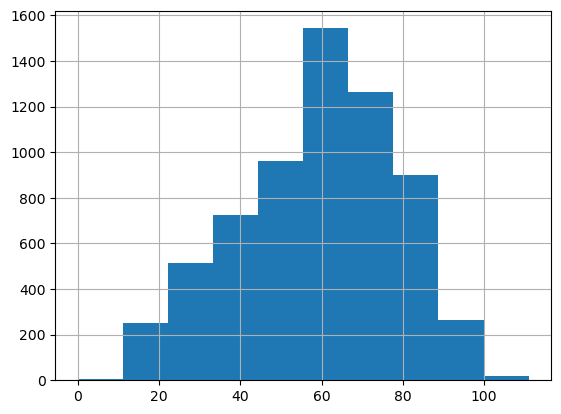

In [66]:
all3_patient[['ID','index_age']].drop_duplicates()['index_age'].hist()

In [93]:
print(np.mean(all3_patient['index_age']))
print([all3_patient['index_age'].quantile(p) for p in np.arange(0,1,0.1)])

58.86037028873705
[0.0, 32.0, 42.0, 50.0, 56.0, 61.0, 65.0, 69.0, 75.0, 82.0]


In [67]:
#lung
lung_patient = diagnosis.loc[diagnosis['DX'].isin(lung_cancer_icd)][['DX','ID','index_age']].drop_duplicates().reset_index(drop=True)

In [69]:
lung_patient

,DX,ID,index_age
0,C34.92,19Oct2022covidpasc00144842,80
1,C34.32,19Oct2022covidpasc00144842,80
2,C34.90,19Oct2022covidpasc00144842,80
3,162.9,19Oct2022covidpasc00146782,47
4,162.3,19Oct2022covidpasc00146782,47
...,...,...,...
4656,C34.90,19Oct2022covidpasc00084515,18
4657,C34.2,19Oct2022covidpasc00084515,18
4658,C34.90,19Oct2022covidpasc00092826,38
4659,C34.92,19Oct2022covidpasc00092826,38


In [71]:
len(lung_patient[['ID','index_age']].drop_duplicates())

1888

<AxesSubplot:>

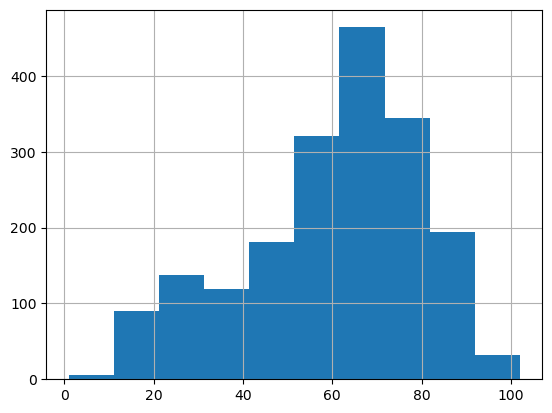

In [72]:
lung_patient[['ID','index_age']].drop_duplicates()['index_age'].hist()

In [92]:
print(np.mean(lung_patient['index_age']))
print([lung_patient['index_age'].quantile(p) for p in np.arange(0,1,0.1)])

60.26775370092255
[1.0, 30.0, 44.0, 55.0, 60.0, 63.0, 67.0, 71.0, 76.0, 82.0]


In [73]:
colorectal_patient = diagnosis.loc[diagnosis['DX'].isin(colorectal_cancer_icd)][['DX','ID','index_age']].drop_duplicates().reset_index(drop=True)
len(colorectal_patient['ID'].drop_duplicates())

1806

<AxesSubplot:>

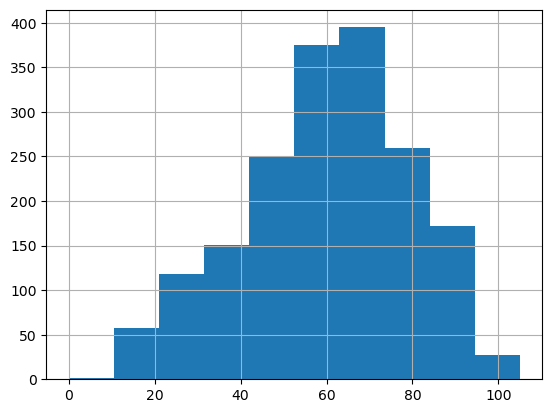

In [74]:
colorectal_patient[['ID','index_age']].drop_duplicates()['index_age'].hist()

In [91]:
print(np.mean(colorectal_patient['index_age']))
print([colorectal_patient['index_age'].quantile(p) for p in np.arange(0,1,0.1)])

59.418386941910704
[0.0, 33.0, 43.0, 51.0, 57.0, 61.0, 65.0, 69.5, 76.0, 83.0]


In [76]:
breast_patient = diagnosis.loc[diagnosis['DX'].isin(breast_cancer_icd)][['DX','ID','index_age']].drop_duplicates().reset_index(drop=True)
len(breast_patient[['ID','index_age']].drop_duplicates())

3158

<AxesSubplot:>

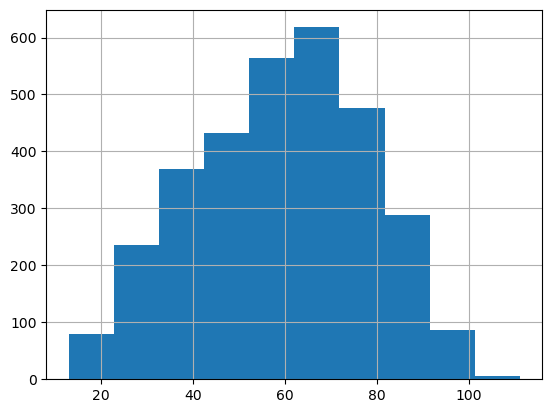

In [77]:
breast_patient[['ID','index_age']].drop_duplicates()['index_age'].hist()

In [90]:
print(np.mean(breast_patient['index_age']))
print([breast_patient['index_age'].quantile(p) for p in np.arange(0,1,0.1)])

57.90719879841219
[13.0, 33.0, 41.0, 48.0, 54.0, 59.0, 63.0, 68.0, 74.0, 81.0]


In [ ]:
#all cancer

In [46]:
#cond 9 

In [99]:
diagnosis.DX_TYPE.value_counts()

10    110315784
9      25115972
10      1315678
09       242782
SM         4268
OT           61
Name: DX_TYPE, dtype: int64

# 2. Exploratory Data Analysis

## 2.1 All

In [48]:
#take the positive cases
index_date_case = index_date.loc[index_date['group']=='case']
index_date_control = index_date.loc[index_date['group']=='cont']

In [50]:
index_date_case['index_date']=pd.to_datetime(index_date_case['index_date'])
index_date_case['pasc_onset_date']=pd.to_datetime(index_date_case['pasc_onset_date'])
index_date_control['index_date']=pd.to_datetime(index_date_control['index_date'])

/tmp/ipykernel_4228/278145710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_date_case['index_date']=pd.to_datetime(index_date_case['index_date'])
/tmp/ipykernel_4228/278145710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_date_case['pasc_onset_date']=pd.to_datetime(index_date_case['pasc_onset_date'])
/tmp/ipykernel_4228/278145710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [77]:
index_date_processed = pd.concat([index_date_case,index_date_control])

In [69]:
len(index_date_case),len(index_date_control),len(index_date_case)+len(index_date_control)

(5651, 224041, 229692)

In [70]:
#index_date_case['time_to_pasc'] = index_date_case.apply(lambda x: relativedelta( x.pasc_onset_date,x.index_date).days, axis=1)
#index_date_control['time_to_pasc'] = np.nan

In [74]:
index_date_nonna = index_date.loc[~(index_date['index_date'].isna())] 
index_date_case_nonna = index_date_nonna.loc[index_date['group']=='case']
index_date_control_nonna = index_date_nonna.loc[index_date['group']=='cont']

In [75]:
len(index_date_case_nonna),len(index_date_control_nonna),len(index_date_case_nonna)+len(index_date_control_nonna)

(1937, 224041, 225978)

In [98]:
#date of events
min(index_date_processed['index_date'].dropna()),max(index_date_processed['index_date'].dropna())

(Timestamp('2020-03-01 00:00:00'), Timestamp('2022-06-04 00:00:00'))

In [99]:
min(index_date_processed['pasc_onset_date'].dropna()),max(index_date_processed['pasc_onset_date'].dropna())

(Timestamp('2020-06-24 00:00:00'), Timestamp('2022-05-25 00:00:00'))

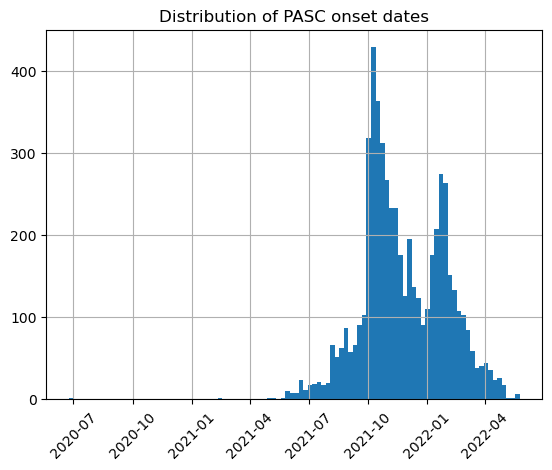

In [95]:
index_date_processed['pasc_onset_date'].dropna().hist(bins=100)
plt.xticks(rotation=45,fontsize=10)
plt.title('Distribution of PASC onset dates')
plt.show()

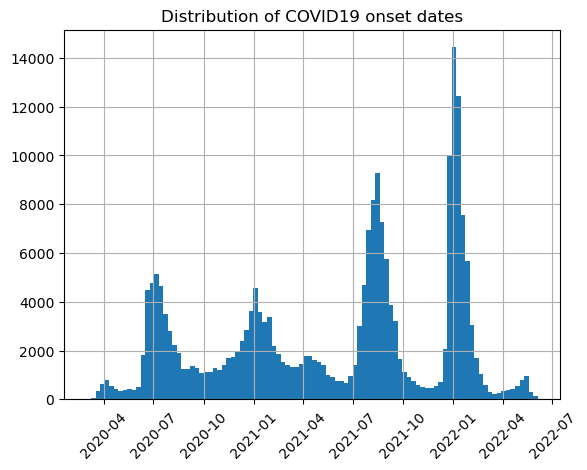

In [96]:
index_date_processed['index_date'].dropna().hist(bins=100)
plt.xticks(rotation=45,fontsize=10)
plt.title('Distribution of COVID19 onset dates')
plt.show()

In [ ]:
#race ethnicity

In [101]:
#distribution of covid to pasc date
index_date_processed_pasc_nonna = index_date_processed.loc[(~index_date_processed['index_date'].isna())&(~index_date_processed['pasc_onset_date'].isna())]
index_date_processed_pasc_nonna['time_to_pasc'] = index_date_processed_pasc_nonna.apply(lambda x: relativedelta( x.pasc_onset_date,x.index_date).days, axis=1)

/tmp/ipykernel_4228/1129743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_date_processed_pasc_nonna['time_to_pasc'] = index_date_processed_pasc_nonna.apply(lambda x: relativedelta( x.pasc_onset_date,x.index_date).days, axis=1)


In [103]:
index_date_processed_pasc_nonna.loc[index_date_processed_pasc_nonna['time_to_pasc']<0]

,ID,index_date,pasc_onset_date,group,time_to_pasc
8622,19Oct2022covidpasc00068949,2022-01-25,2022-01-18 00:00:00,case,-7
9488,19Oct2022covidpasc00076115,2021-12-16,2021-12-09 00:00:00,case,-7
10754,19Oct2022covidpasc00085481,2021-12-08,2021-11-10 00:00:00,case,-28
13927,19Oct2022covidpasc00112054,2022-01-21,2022-01-20 00:00:00,case,-1
14066,19Oct2022covidpasc00112193,2022-03-23,2022-02-17 00:00:00,case,-6
...,...,...,...,...,...
202520,19Oct2022covidpasc00007930,2021-10-29,2021-08-23 00:00:00,case,-6
205968,19Oct2022covidpasc00039277,2021-12-26,2021-10-14 00:00:00,case,-12
215745,19Oct2022covidpasc00118354,2021-12-02,2021-12-01 00:00:00,case,-1
221942,19Oct2022covidpasc00165051,2022-01-12,2021-09-27 00:00:00,case,-15


Text(0.5, 1.0, 'Days from COVID19 index date to PASC onset date')

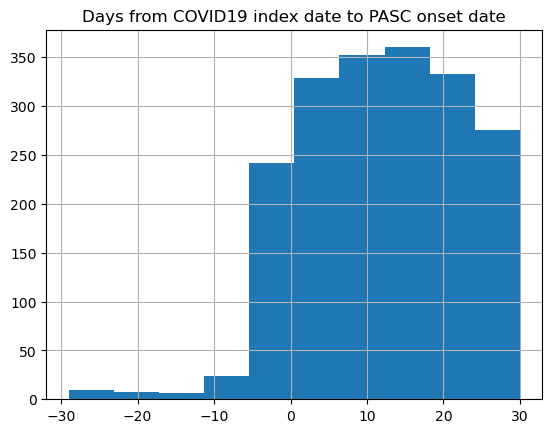

In [104]:
index_date_processed_pasc_nonna['time_to_pasc'].hist()
plt.title('Days from COVID19 index date to PASC onset date')

In [105]:
#race and ethnicity

,ID,BIRTH_DATE,BIRTH_TIME,SEX,SEXUAL_ORIENTATION,GENDER_IDENTITY,HISPANIC,RACE,BIOBANK_FLAG,PAT_PREF_LANGUAGE_SPOKEN,ZIP_CODE,SOURCE_masked
0,19Oct2022covidpasc00121586,1991-10-04,00:00,F,NaN,NaN,N,05,N,ENG,327769298,source_12
1,19Oct2022covidpasc00125493,1947-04-10,00:00,M,NaN,NaN,N,05,N,ENG,328188842,source_11
2,19Oct2022covidpasc00008560,1961-08-09,00:00,M,NaN,NaN,Y,05,N,ENG,347412932,source_12
3,19Oct2022covidpasc00183957,1975-10-15,00:00,F,NaN,NaN,N,05,N,ENG,327145836,source_12
4,19Oct2022covidpasc00184103,1993-07-07,00:00,M,NaN,NaN,Y,05,N,NaN,33837,source_12
...,...,...,...,...,...,...,...,...,...,...,...,...
227288,19Oct2022covidpasc00053917,1984-02-17,19:00,M,NaN,NaN,N,05,N,ENG,327123851,source_12
227289,19Oct2022covidpasc00158354,1988-06-03,NaN,F,NI,NaN,UN,UN,NaN,NI,32301,source_15
227290,19Oct2022covidpasc00023017,1983-12-05,00:00,M,NI,NI,N,05,N,ENG,33513-8203,source_3
227291,19Oct2022covidpasc00041748,1997-10-20,00:00,M,NaN,NaN,Y,05,N,ENG,347446148,source_12


In [114]:
demographics_trimmed = demographics_trimmed

In [115]:
demographics_trimmed.shape,demographics.shape

((229689, 12), (455995, 12))

In [127]:
demographics_trimmed = demographics_trimmed.merge(index_date_processed,on='ID',how='left')

In [132]:
demographics_trimmed['PASC_indicator'] = (~demographics_trimmed['pasc_onset_date'].isna())*1

In [133]:
demographics_trimmed_race = demographics_trimmed.groupby('RACE').agg({'ID':'size',
                                                                      'PASC_indicator':'sum'}).reset_index()
demographics_trimmed_race.columns = ['RACE','Num_Patients','PASC_Patients']

In [134]:
demographics_trimmed_race['RACE'] = demographics_trimmed_race['RACE'].replace({'01':'American_Indian_or_Alaska_Native ',
                                                                               '02':'Asian',
                                                                               '03':'Black_or_African_American',
                                                                               '04':'Native_Hawaiian_or_Other',
                                                                               '05':'White',
                                                                               '06':'Multiplce_Race',
                                                                               '07':'Refuse_to_Answer',
                                                                               'NI':'No_Information',
                                                                               'OT':'Other',
                                                                               'UN':'Unknown'})

In [141]:
demographics_trimmed_race['PASC_incidence(%)'] =np.round(100*demographics_trimmed_race['PASC_Patients']/demographics_trimmed_race['Num_Patients'],2)

In [142]:
demographics_trimmed_race.sort_values('Num_Patients',ascending=False).reset_index(drop=True)

,RACE,Num_Patients,PASC_Patients,PASC_incidence(%)
0,White,117056,3108,2.66
1,Black_or_African_American,58652,1326,2.26
2,Other,38008,879,2.31
3,Unknown,8577,173,2.02
4,Multiplce_Race,2937,45,1.53
5,Asian,2883,64,2.22
6,American_Indian_or_Alaska_Native,554,20,3.61
7,Refuse_to_Answer,500,25,5.00
8,No_Information,171,5,2.92
9,Native_Hawaiian_or_Other,164,3,1.83


In [143]:
#gender
demographics_trimmed_gender = demographics_trimmed.groupby('SEX').agg({'ID':'size',
                                                                      'PASC_indicator':'sum'}).reset_index()
demographics_trimmed_gender.columns = ['GENDER','Num_Patients','PASC_Patients']

In [148]:
demographics_trimmed_gender['GENDER'] = demographics_trimmed_gender['GENDER'].replace({
                                                                               'NI':'No_Information',
                                                                               'OT':'Other',
                                                                               'UN':'Unknown'})

In [149]:
demographics_trimmed_gender['PASC_incidence(%)'] =np.round(100*demographics_trimmed_gender['PASC_Patients']/demographics_trimmed_gender['Num_Patients'],2)

In [150]:
demographics_trimmed_gender.sort_values('Num_Patients',ascending=False).reset_index(drop=True)

,GENDER,Num_Patients,PASC_Patients,PASC_incidence(%)
0,F,135099,3465,2.56
1,M,94549,2186,2.31
2,No_Information,20,0,0.00
3,Unknown,12,0,0.00
4,Other,9,0,0.00


In [151]:
#age (group?)
demographics_trimmed_nonna = demographics_trimmed.loc[~demographics_trimmed['index_date'].isna()]

In [153]:
#define function for calculating ages
def calc_age(born_d,index_d):
   return index_d.year - born_d.year - ((index_d.month, 
                                      index_d.day) < (born_d.month, 
                                                    born_d.day))

In [154]:
demographics_trimmed_nonna['BIRTH_DATE']=pd.to_datetime(demographics_trimmed_nonna['BIRTH_DATE'])
demographics_trimmed_nonna['index_date']=pd.to_datetime(demographics_trimmed_nonna['index_date'])

/tmp/ipykernel_4228/712567273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_trimmed_nonna['BIRTH_DATE']=pd.to_datetime(demographics_trimmed_nonna['BIRTH_DATE'])
/tmp/ipykernel_4228/712567273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_trimmed_nonna['index_date']=pd.to_datetime(demographics_trimmed_nonna['index_date'])


In [155]:
demographics_trimmed_nonna['COVID19_age'] = demographics_trimmed_nonna.apply(lambda x: calc_age(x.BIRTH_DATE, x.index_date), axis=1)

/tmp/ipykernel_4228/1277798201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_trimmed_nonna['COVID19_age'] = demographics_trimmed_nonna.apply(lambda x: calc_age(x.BIRTH_DATE, x.index_date), axis=1)


In [160]:
demographics_trimmed_nonna['COVID19_age_band'] = pd.cut(demographics_trimmed_nonna.COVID19_age, \
                                    [0,10,20,30,40,50,60,70,80,999],\
                                    labels = ['0~9','10~19','20~29','30~39','40~49','50~59','60~69','70~79','80~'],\
                                    include_lowest=True,right=False)

/tmp/ipykernel_4228/2525940481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_trimmed_nonna['COVID19_age_band'] = pd.cut(demographics_trimmed_nonna.COVID19_age, \


In [162]:
demographics_trimmed_age = demographics_trimmed_nonna.groupby('COVID19_age_band').agg({'ID':'size',
                                                                      'PASC_indicator':'sum'}).reset_index()
demographics_trimmed_age.columns = ['COVID19_age_band','Num_Patients','PASC_Patients']

In [163]:
demographics_trimmed_age['PASC_incidence(%)'] =np.round(100*demographics_trimmed_age['PASC_Patients']/demographics_trimmed_age['Num_Patients'],2)

In [164]:
demographics_trimmed_age

,COVID19_age_band,Num_Patients,PASC_Patients,PASC_incidence(%)
0,0~9,14126,38,0.27
1,10~19,26692,179,0.67
2,20~29,41481,333,0.80
3,30~39,36645,313,0.85
4,40~49,30568,292,0.96
5,50~59,26932,263,0.98
6,60~69,21510,233,1.08
7,70~79,15349,164,1.07
8,80~,12672,122,0.96


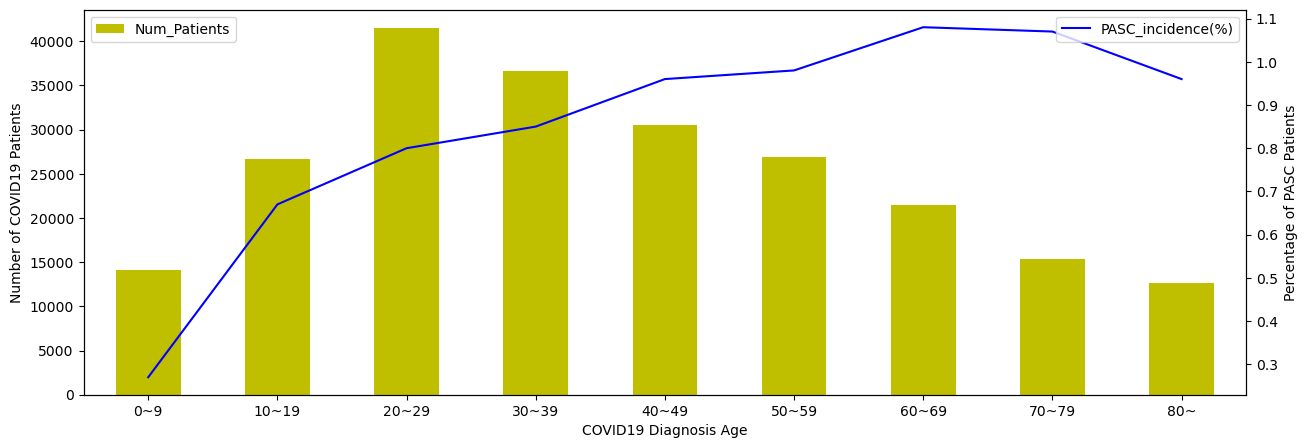

In [189]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

demographics_trimmed_age[['COVID19_age_band','Num_Patients']].plot(kind='bar', color='y', ax=ax1)
demographics_trimmed_age[['COVID19_age_band','PASC_incidence(%)']].plot(kind='line', color='b', ax=ax2)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticklabels(demographics_trimmed_age['COVID19_age_band'],rotation=0)
ax1.set_xlabel('COVID19 Diagnosis Age')
ax1.set_ylabel('Number of COVID19 Patients')
ax2.set_ylabel('Percentage of PASC Patients')
plt.show()


## 2.2. Cancer